# T-SNE & U-Map Interactive

In [1]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
import umap.plot
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from ketos.data_handling.data_feeding import JointBatchGen
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
import ketos.data_handling.database_interface as dbi

C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)
C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [2]:
def feature_extractor(pre_trained_model):
    extractor = tf.keras.models.Sequential(pre_trained_model.model.layers[0:4])
    extractor.trainable = False
    return extractor

In [3]:
thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

output_dir = r'E:\baseline-with-normalization-reduce-tonal\metrics'
main_folder = r'E:\baseline-with-normalization-reduce-tonal'
db_name = main_folder + '\\' + 'final-baseline-db-normalized-rtn.h5'
model_name = main_folder + '\\' + 'rs-model-0.kt'
temp_folder = main_folder + '\\' + 'temp'

In [4]:
db = dbi.open_file(db_name, 'r')
table = dbi.open_table(db, '/test')
classification_csv = "classifications.csv"
metric_csv = "metrics.csv"
stats_csv = "stats.csv"

model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)
gens = []
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
simplified = feature_extractor(model)

scores = []
labels = []
output = []

for batch_id in range(gen.n_batches):
    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

    # get array for each of size (64,)
    output.extend(simplified(batch_X))

In [5]:
output_numpy = [x.numpy() for x in output]
df = pd.DataFrame(output_numpy)

## U-Map

### Not Interactive

<Axes: >

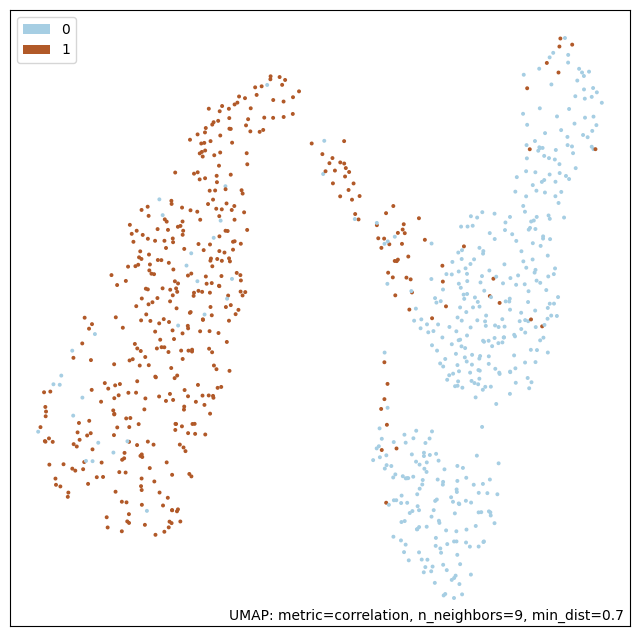

In [6]:
mapper = umap.UMAP(n_neighbors=9, min_dist=0.7, metric='correlation', n_components=2).fit(df)

umap.plot.points(mapper, labels=np.array(labels), color_key_cmap='Paired', background='white')

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

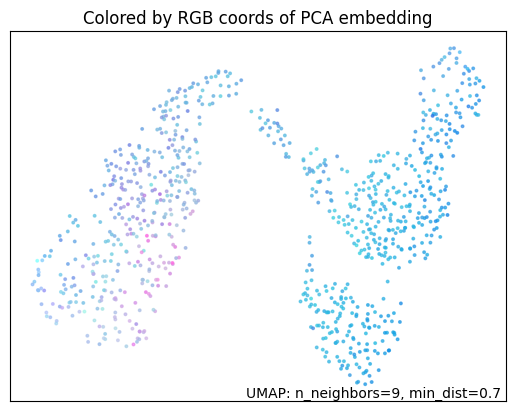

In [7]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

### Interactive

In [8]:
umap.plot.output_notebook()

Loading BokehJS ...

In [9]:
mapper = umap.UMAP(n_neighbors=9, min_dist=0.7, metric='correlation', n_components=2).fit(df)

hover_data = pd.DataFrame({'index':np.arange(len(labels)),
                           'label':labels})

p = umap.plot.interactive(mapper, labels=labels, hover_data=hover_data, point_size=12, color_key_cmap='Paired', background='white')
umap.plot.show(p)

C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\umap\plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(
C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\datashader\transfer_functions\__init__.py:326: RuntimeWarning: invalid value encountered in divide
  scaled_data = (data - span[0])/(span[1] - span[0])


<Axes: >

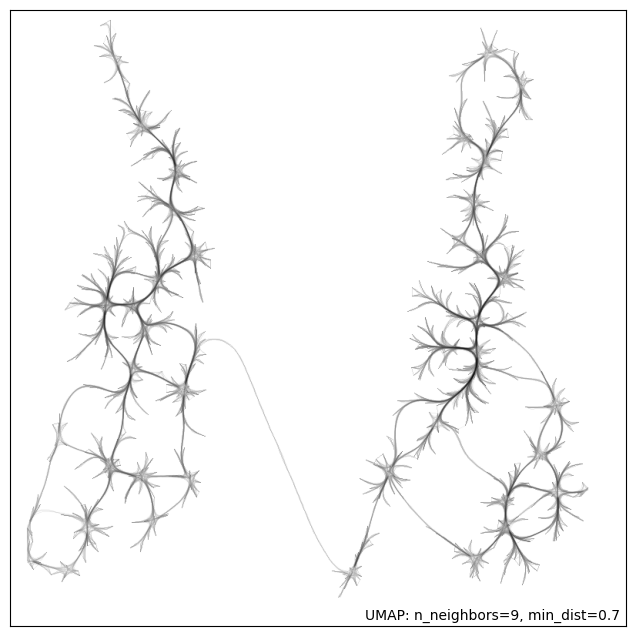

In [10]:
umap.plot.connectivity(mapper, show_points=True, edge_bundling='hammer')

## T-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 894 samples in 0.002s...
[t-SNE] Computed neighbors for 894 samples in 0.296s...
[t-SNE] Computed conditional probabilities for sample 894 / 894
[t-SNE] Mean sigma: 0.235160
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.100128
[t-SNE] KL divergence after 300 iterations: 0.603908


C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


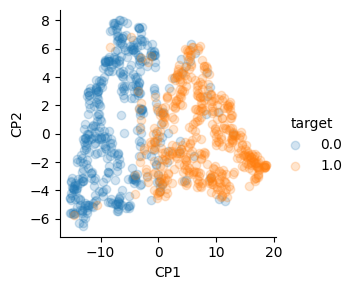

In [11]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df)
tsne_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'], data=np.column_stack((tsne_results, labels)))
grid = sns.FacetGrid(tsne_df, hue="target")
grid.map(plt.scatter, 'CP1', 'CP2', alpha=0.2).add_legend()
plt.show()

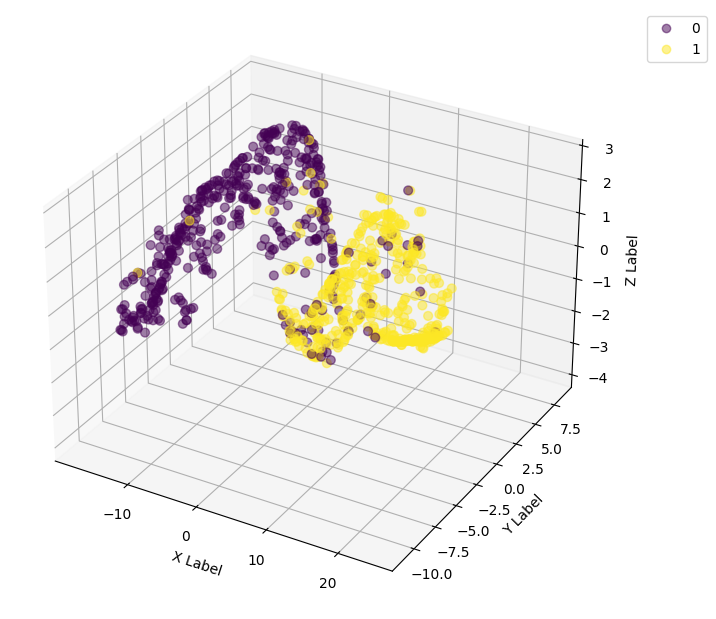

In [12]:
tsne_3d = TSNE(n_components=3, random_state=0)
projections = tsne_3d.fit_transform(df)
tsne_df3d = pd.DataFrame(columns=['CP1', 'CP2', 'CP3', 'target'], data=np.column_stack((projections, labels)))

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

sc = ax.scatter(tsne_df3d['CP1'], tsne_df3d['CP2'], tsne_df3d['CP3'], s=40, c=tsne_df3d['target'], marker='o', cmap='viridis', alpha=0.5)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.show()

## References
UMAP Site: https://umap-learn.readthedocs.io/en/latest/plotting.html